In [344]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud

from textblob import TextBlob
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [2]:
import csv
import webbrowser
import io

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [177]:
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Scrape reviews from TripAdvisor
#Data cleaning
#Sentiment analysis: Plot word clouds (maybe build a sentiment analysis to compare)
#Look at positive and negative reviews, topic modelling for negative reviews

The following code scrap 500 TripAdvisor reviews of British Museum.

In [159]:
from random import randint
from time import sleep
import re

#rn = [n*5 for n in range(0,102)]
rn = [n*5 for n in range(0,102)]
first_url = 'https://www.tripadvisor.com.my/Attraction_Review-g186338-d187555-Reviews-The_British_Museum-London_England.html#REVIEWS'

links = []
links.append(first_url)
info = []
reviewer_date = []
reviewer_text = []
reviewer_stars = []
for r in rn:
    html2 = requests.get(links[int(r/5)])
    sleep(randint(1,5))
    soup = BeautifulSoup(html2.text, "html.parser")
    
    review_box = soup.find_all('div',{'class':'Dq9MAugU T870kzTX LnVzGwUB'})
    
    for i in review_box:
        date = i.find('span', {'class': '_34Xs-BQm'})
        date = re.findall('perience:</span> ([a-zA-Z0-9 ]+)</sp',str(date))
        reviewer_date.append(date)
    
    
    for i in review_box:
        reviewer_text.append(i.find('q', {'class': 'IRsGHoPm'}).text.strip()) 
        

    for i in review_box:
        stars = i.find('div', {'class': 'nf9vGX55'})
        stars = re.findall('ing bubble_(\d)', ''.join(map(str, stars)))
        reviewer_stars.append(stars)
    
    
    dynamic_url = 'https://www.tripadvisor.com.my/Attraction_Review-g186338-d187555-Reviews-or' + str(r) + '-The_British_Museum-London_England.html'
    links.append(dynamic_url)

#info.append([visit_date, reviewer_text, stars])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:34: DeprecationWarning: invalid escape sequence \d
<>:34: DeprecationWarning: invalid escape sequence \d
<ipython-input-159-7585774f53f9>:34: DeprecationWarning: invalid escape sequence \d
  stars = re.findall('ing bubble_(\d)', ''.join(map(str, stars)))


In [181]:
reviews = pd.DataFrame({'Visit date': reviewer_date, 'Review': reviewer_text, 'Rating': reviewer_stars})
#reviews['Name'] = reviews['Name'].apply(lambda x: ''.join(x))
reviews['Visit date'] = reviews['Visit date'].apply(lambda x: ''.join(x))
#reviews['Reviewer origin'] = reviews['Reviewer origin'].apply(lambda x: ''.join(x))
reviews['Review'] = reviews['Review'].apply(lambda x: ''.join(x))
reviews['Rating'] = reviews['Rating'].apply(lambda x: ''.join(x))

reviews

,Visit date,Review,Rating
0,December 2020,I went to this museum only last week and I was...,5
1,December 2020,Decided to book a visit before we go into tier...,4
2,December 2020,This exhibition is very well presented and giv...,5
3,December 2020,Clean and quiet.... If you have time for museu...,5
4,February 2020,My family member has got his paintings here s...,3
...,...,...,...
495,January 2020,Always something new to discover and learn. Ve...,4
496,February 2019,Collection of antiquities is absolutely stunni...,5
497,January 2020,Amazing venue. Loved it. Fascinating exhibitio...,5
498,December 2019,Wonderful building. Interesting artefacts from...,5


In [180]:
reviews.to_csv('BM_tripadvisor.csv')

In [179]:
reviews['Rating'] = reviews['Rating'].apply(lambda x: int(x))

In [374]:
rating_dist = reviews.groupby('Rating').agg('count')[['Review']]
print("Distribution of Tripadvisor ratings:")
rating_dist.reset_index("Rating")

Distribution of Tripadvisor ratings:


,Rating,Review
0,1,10
1,2,11
2,3,28
3,4,110
4,5,341


Text(0.5, 1.0, 'British Museum Tripadvisor ratings in 2020')

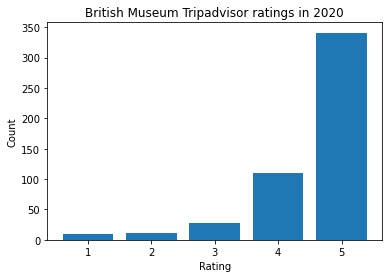

In [213]:
plt.bar(rating_dist.index, rating_dist['Review'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('British Museum Tripadvisor ratings in 2020')


In [265]:
#Data cleaning
#Normalize
#Tokenize (with regex)
#Pos tag (convert to word net pos tag)
#Remove stop words
#Lemmatize
#Word cloud

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN

#lemmatize
def lemmatize_tokens(text):
    text = text.lower()
    pattern = r'\b[a-zA-Z]{3,}\b'
    tokens = nltk.regexp_tokenize(text, pattern)
    token_tag = nltk.pos_tag(tokens)
    
    stop_words = stopwords.words('english')
    more_stopwords = ['museum', 'visit', 'see', 'even', 'well', 'great', 'day',
                     'back', 'go', 'always', 'spend', 'though', 'inside', 'go',
                     'wonderful', 'much', 'really', 'many', 'let', 'around']
    stop_words.extend(more_stopwords)
    stop_words = set(stop_words)
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) 
                                             for (word, tag) in token_tag
                                             if word not in stop_words and
                                             word not in string.punctuation]
    return lemmatized_words
    

In [266]:
text = reviews['Review'].tolist()
lem_token = ' '.join(lemmatize_tokens(' '.join(text)))


In [267]:
wordcloud = WordCloud(collocations = False,
                     background_color = 'white',
                     width = 1600,
                     height = 800,
                     margin = 2,
                     min_font_size = 20)
wordcloud.generate(lem_token)

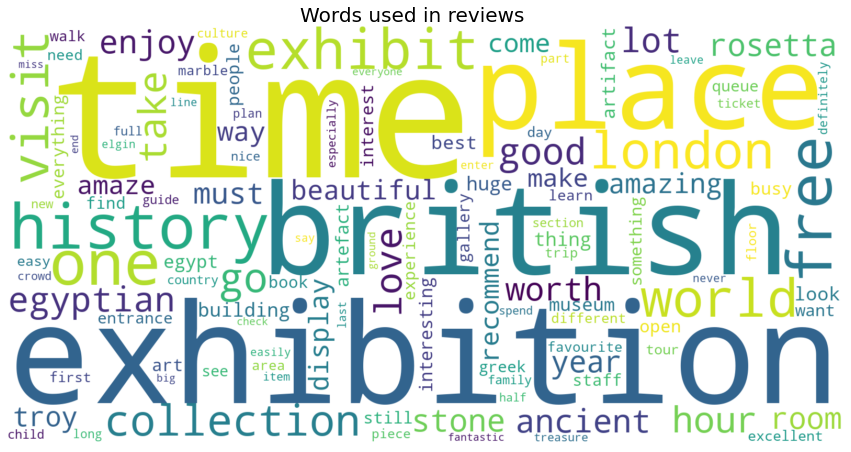

In [268]:
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.figtext(.5, .8, 'Words used in reviews', fontsize = 20, ha = 'center')
plt.show()

In [269]:
#reviews.astype({'Rating': 'int32'}).dtypes
reviews['Rating'] = pd.to_numeric(reviews['Rating'])

In [270]:
pos_reviews = reviews[reviews['Rating'] > 3]

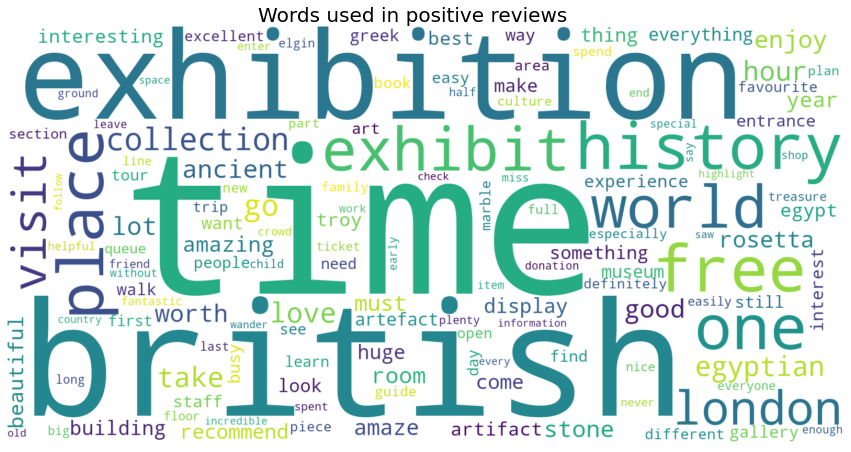

In [271]:
positive_text = pos_reviews['Review'].tolist()
positive_token = ' '.join(lemmatize_tokens(' '.join(positive_text)))

pos_wordcloud = wordcloud.generate(positive_token)
plt.figure(figsize = (15,10))
plt.imshow(pos_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.figtext(.5, .8, 'Words used in positive reviews', fontsize = 20, ha = 'center')
plt.show()


Positive reviews were about the museum's exhibition, free-of-charge policy, its collections and the history.

In [272]:
neg_reviews = reviews[reviews['Rating'] < 3]

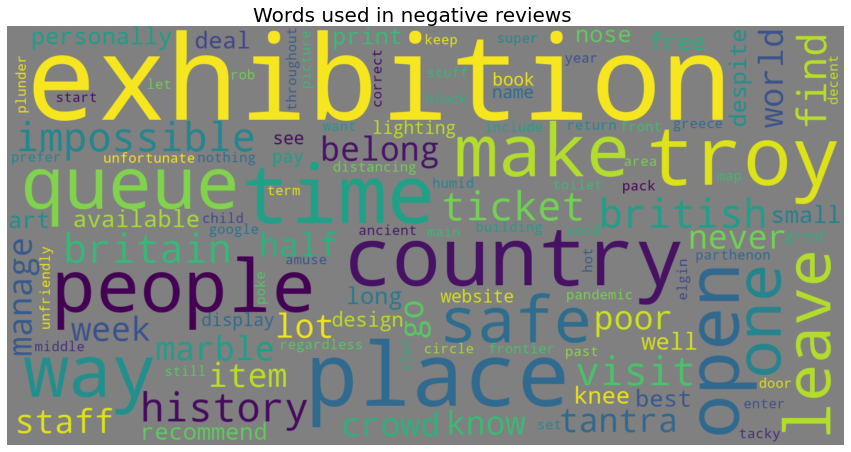

In [273]:
negative_text = neg_reviews['Review'].tolist()
negative_token = ' '.join(lemmatize_tokens(' '.join(negative_text)))

neg_wordcloud = WordCloud(collocations = False,
                background_color = 'gray',
                     width = 1600,
                     height = 800,
                     margin = 2,
                     min_font_size = 20).generate(negative_token)

plt.figure(figsize = (15,10))
plt.imshow(neg_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.figtext(.5, .8, 'Words used in negative reviews', fontsize = 20, ha = 'center')
plt.show()


The negative reviews were mostly regarding the museum's exhibitions (the Troy exhibition was mentioned negatively more than the Tantra exhibition), there were also complaints about the staff and the crowd. Surprisingly, there were fewer mentions of the word "plunder".

In [275]:
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def polarity(text):
    return TextBlob(text).sentiment.polarity

reviews['Subjectivity'] = reviews['Review'].apply(subjectivity)
reviews['Polarity'] = reviews['Review'].apply(polarity)

def sentiment(rating):
    if rating < 3:
        return 'Negative'
    if rating > 3:
        return 'Positive'
    else:
        return 'Neutral'
reviews['Sentiment'] = reviews['Rating'].apply(sentiment)

Text(0.5, 1.0, 'Subjectivity vs Polarity of British Museum Tripadvisor Reviews')

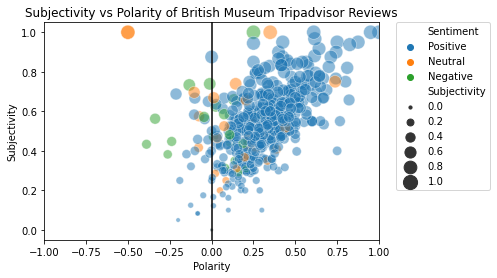

In [297]:
sns.scatterplot(x = 'Polarity', y = 'Subjectivity', data = reviews,
           hue = 'Sentiment', size= 'Subjectivity', sizes=(10, 200),
            alpha = 0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-1, 1)
plt.axvline(0, color='k', linestyle='solid')
plt.title('Subjectivity vs Polarity of British Museum Tripadvisor Reviews')

As expected, the more positive/negative the reviews got, the more subjective it became.

In [346]:
#Do LDA for positive reviews
#Convert text to dtm
#Train model

pos_text = pos_reviews['Review'].tolist()

stop_words = ENGLISH_STOP_WORDS.union(["museum", "really", "good",
                                           "great", "excellent"])

tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                ngram_range=(1,2),
                                stop_words = stop_words,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.9,
                                min_df = 10)
dtm = tfidf_vectorizer.fit_transform(pos_text)
dtm.shape


(451, 146)

In [347]:
print('There are {} positive reviews and {} tokens in the resulting document-term matrix.'
      .format(dtm.shape[0], dtm.shape[1]))

There are 451 positive reviews and 146 tokens in the resulting document-term matrix.


In [348]:
search_grid = {'n_components': [2, 5, 10, 15, 20, 25, 30],
                'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid = search_grid)
model.fit(dtm)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 5, 10, 15, 20, 25, 30]})

In [349]:
best_model = model.best_estimator_
best_model
#The optimum LDA has 2 topics

LatentDirichletAllocation(learning_decay=0.9, n_components=2)

In [350]:
print("The best model has parameters:", model.best_params_)

The best model has parameters: {'learning_decay': 0.9, 'n_components': 2}


In [351]:
print("Log likelihood of the best model is:", model.best_score_)

Log likelihood of the best model is: -1441.7965911636097


In [352]:
print("Perplexity of the best model is:", best_model.perplexity(dtm))

Perplexity of the best model is: 201.5689127679336


In [353]:
#Plot log-likelihood vs number of topics
iter_score = model.fit(dtm).cv_results_

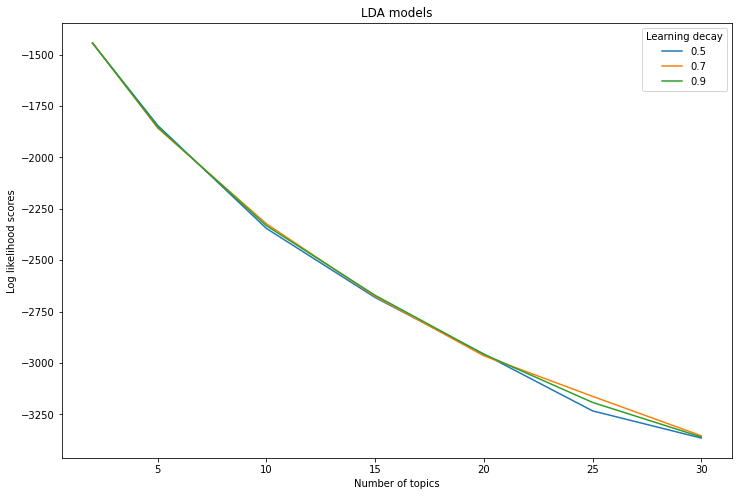

In [354]:
n_topics = [2, 5, 10, 15, 20, 25, 30]
decay_5 = [iter_score['mean_test_score'][iter_score['params'].index(v)] for v in iter_score['params'] if v['learning_decay'] == 0.5]
decay_7 = [iter_score['mean_test_score'][iter_score['params'].index(v)] for v in iter_score['params'] if v['learning_decay'] == 0.7]
decay_9 = [iter_score['mean_test_score'][iter_score['params'].index(v)] for v in iter_score['params'] if v['learning_decay'] == 0.9]

plt.figure(figsize=(12,8))
plt.plot(n_topics, decay_5, label = '0.5')
plt.plot(n_topics, decay_7, label = '0.7')
plt.plot(n_topics, decay_9, label = '0.9')
plt.title('LDA models')
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood scores')
plt.legend(title = 'Learning decay', loc = 'best')
plt.show()

Learning decay does not have a significant effect on the training of the LDA model.

In [355]:
best_model.components_

topic_dict = {}
topic_words = tfidf_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(best_model.components_):
    topic_dict['Topic %d words' %(topic_idx+1)] = ['{}'.format(topic_words[i])
                                                    for i in topic.argsort()[:-21:-1]]
    topic_dict['Topic %d weights' %(topic_idx+1)] = ['{}'.format(topic[i]) 
                                                     for i in topic.argsort()[:-21:-1]]


pd.DataFrame(topic_dict)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,visit,18.74067959465114,british,24.350206502400734
1,exhibition,17.666941924336086,london,19.278813444548412
2,interesting,14.7719026586185,history,19.130825905526606
3,hours,13.848373766108798,world,18.219453402610565
4,worth,12.548194866030437,amazing,17.114659830224888
5,exhibits,10.132746977526034,free,15.869938717648683
6,went,10.093427446735516,visit,15.207697379699521
7,troy,9.937185453678433,collection,14.8092284911774
8,recommend,9.875667801289227,place,13.278951243193994
9,spent,9.765057642873714,egyptian,12.86808999116456


Positive reviews of the museum were mainly about 2 topics: its temporary exhibitions (one of which is the Troy exhibition) and its permanent exhibitions. 

The collections displayed in the permanent collection, e.g. items in the Egyptian gallery and the Rosetta Stone were mentioned frequently in the positive reviews, as well as the fact that its entrance is free of charge.

In [368]:
#Topic modelling for negative reviews
neg_text = neg_reviews['Review'].tolist()

neg_stop_words = ENGLISH_STOP_WORDS.union(["way", "left"])

neg_tfidf_vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                ngram_range=(1,2),
                                stop_words = stop_words,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.9,
                                min_df = 3)
dtm_neg = neg_tfidf_vectorizer.fit_transform(neg_text)
dtm_neg.shape

(21, 13)

In [369]:
print('There are {} negative reviews and {} tokens in the resulting document-term matrix.'
      .format(dtm_neg.shape[0], dtm_neg.shape[1]))

There are 21 negative reviews and 13 tokens in the resulting document-term matrix.


In [370]:
neg_search_grid = {'n_components': [2, 5, 10],
                'learning_decay': [.5, .7, .9]}
neg_lda = LatentDirichletAllocation()
neg_model = GridSearchCV(neg_lda, param_grid = neg_search_grid)
neg_model.fit(dtm_neg)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 5, 10]})

In [371]:
best_neg_model = neg_model.best_estimator_
best_neg_model

LatentDirichletAllocation(learning_decay=0.5, n_components=2)

The best model has parameters: {'learning_decay': 0.5, 'n_components': 2}
Log likelihood of the best model is: -25.176876106282936
Perplexity of the best model is: 25.312613913273527


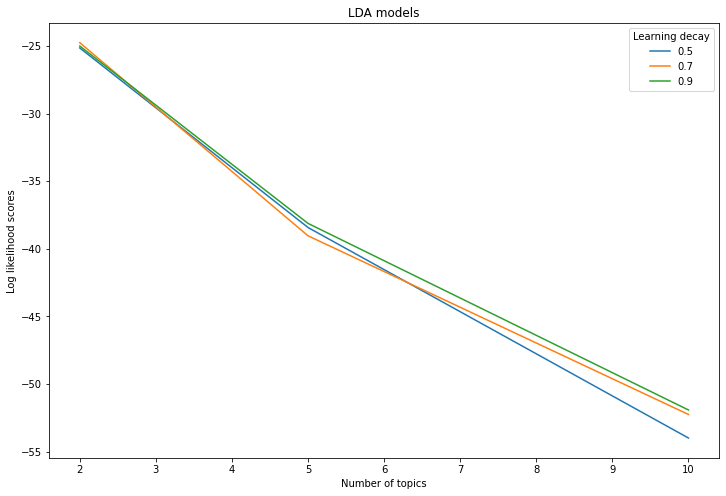

In [372]:
print("The best model has parameters:", neg_model.best_params_)
print("Log likelihood of the best model is:", neg_model.best_score_)
print("Perplexity of the best model is:", best_neg_model.perplexity(dtm_neg))

neg_iter_score = neg_model.fit(dtm_neg).cv_results_
n_topics = [2, 5, 10]
neg_decay_5 = [neg_iter_score['mean_test_score'][neg_iter_score['params'].index(v)] for v in neg_iter_score['params'] if v['learning_decay'] == 0.5]
neg_decay_7 = [neg_iter_score['mean_test_score'][neg_iter_score['params'].index(v)] for v in neg_iter_score['params'] if v['learning_decay'] == 0.7]
neg_decay_9 = [neg_iter_score['mean_test_score'][neg_iter_score['params'].index(v)] for v in neg_iter_score['params'] if v['learning_decay'] == 0.9]

plt.figure(figsize=(12,8))
plt.plot(n_topics, neg_decay_5, label = '0.5')
plt.plot(n_topics, neg_decay_7, label = '0.7')
plt.plot(n_topics, neg_decay_9, label = '0.9')
plt.title('LDA models')
plt.xlabel('Number of topics')
plt.ylabel('Log likelihood scores')
plt.legend(title = 'Learning decay', loc = 'best')
plt.show()

In [373]:
best_neg_model.components_

neg_topic_dict = {}
neg_topic_words = neg_tfidf_vectorizer.get_feature_names()
for topic_idx, topic in enumerate(best_neg_model.components_):
    neg_topic_dict['Topic %d words' %(topic_idx+1)] = ['{}'.format(neg_topic_words[i])
                                                    for i in topic.argsort()[:-21:-1]]
    neg_topic_dict['Topic %d weights' %(topic_idx+1)] = ['{}'.format(topic[i]) 
                                                     for i in topic.argsort()[:-21:-1]]


pd.DataFrame(neg_topic_dict)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,place,4.727307707689172,exhibition,3.8725317698960384
1,countries,3.0190364377546945,troy,2.432116986723054
2,way,1.9715973842207264,crowded,2.39680110443624
3,british,1.9197230057123829,people,2.373893935068149
4,exhibition,1.1501270244687685,left,2.0249810007294093
5,people,0.6539065432724191,tickets,1.7299861780335826
6,inside,0.6533470734343881,troy exhibition,1.7299861774713712
7,left,0.5975962772386412,impossible,1.681742100526906
8,troy,0.5563178402769509,inside,1.5947610117808952
9,impossible,0.5248533095026265,way,0.9633525107898842


Looking at the topic modelling results, it seems like it is more likely that the negative reviews only has one topic. The negative reviews are mostly about the exhibitions and the crowds. The imperialist controversies around British Museum, primarily its acquisition of items of like the Elgin Marbles and the Rosetta Stone were not mentioned as frequently in the reviews.

To improve visitor experience, the museum can work on improving how the exhibitions are organised and crowd management.